In [3]:
import simsz.get_dm_halo as get_dm_halo
import simsz.utils as utils
import make_sz_cluster
import simsz.read_yaml as read_yaml
import simsz.load_vars as load_vars

import time
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd

from astropy.constants import M_sun
from astropy.constants import G, sigma_T, m_e, c, h, k_B
from astropy import units as u

What this notebook currently does: 
- Reads in data from the sim run yaml
- Loads cosmology
- Generates and saves a flat redshift and Mvir distribution as a .txt file
- Loads an existing redshift and Mvir distribution from a .txt file

What this notebook could do, but currently doesn't:
- Generate/use M200 rather than convert from Mvir
- Save m, z dist as .h
- Generates a realistic z, M500 distribution from a given cosmology 

What the modules could be improved to do:
- Streamline the generation of z,M500 distributions by creating a function with options
- Save the z, M500 distribution at the function level in GenerateHalo.py

Problems to be addressed:
- Profile is oddly steep and needs to be checked with Battaglia 2012 realistic z,M, params

In [4]:
ref=read_yaml.YAMLOperator('./simsz/Settings/inputdata.yaml').parse_yaml() #Read in the .yaml for this simulation run 

In [5]:
(survey,survey_freq,beam_size,noise_level,image_size,pixel_scale)=load_vars.load_vars().make_dict(ref) #Make a dictionary from the .yaml

In [6]:
(cosmo,sigma8,ns)=load_vars.load_vars().flatLCDM(ref) #Make cosmology from yaml input parameters 

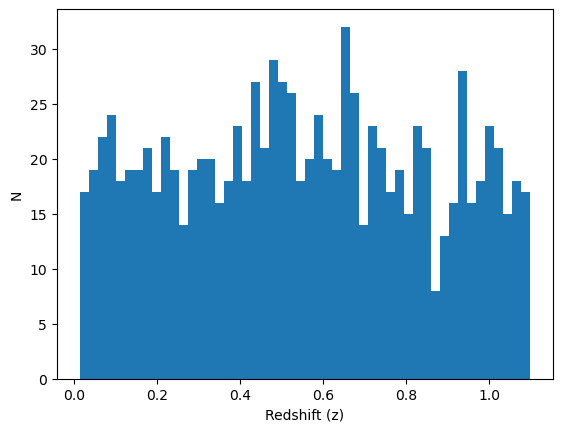

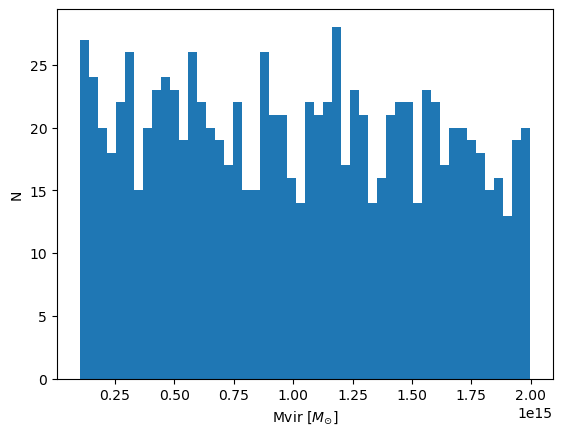

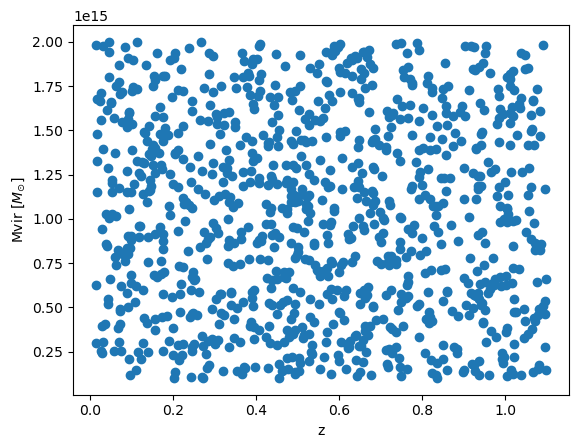

In [7]:
#Generate a new flat z, Mvir distribution and save to file: 
halo=get_dm_halo.GenerateHalo() #Load in get_dm_halo class
szcluster=make_sz_cluster.GenerateCluster() #Load in make_sz_cluster class
nsources=1000 #Number of halos to generate
zdist,mdist=halo.flatdist_halo(0.01,1.1,1e14,2e15,nsources) #Generate a flat z, Mvir distribution for sims

plt.hist(zdist,bins=50) #Show the z distribution 
plt.ylabel('N'),plt.xlabel('Redshift (z)')
plt.show()
plt.hist(mdist,bins=50) #Show the M500 distribution 
plt.ylabel('N'),plt.xlabel(r'Mvir [$M_{\odot}$]')
plt.show()
plt.plot(zdist,mdist,'o') #Show the z, M500 scatterplot
plt.xlabel('z'),plt.ylabel(r'Mvir [$M_{\odot}$]')
plt.show()

sourceid=int(time.time()) #Create an initial ctime for the halo ID list to save catalog
idlist=[sourceid+x for x in range(len(zdist))] #Create the halo ID list for catalog

np.savetxt('flatmassdist.csv',np.array([zdist,mdist,idlist]).T,delimiter=',') #Save this array to txt

In [8]:
#Load an existing z, M array from txt file
d=np.loadtxt('flatmassdist.csv',delimiter=',') 
zdist=d[:,0]
mdist=d[:,1]
idlist=d[:,2]

In [9]:
r=np.linspace(0.01,10,10000) #arcmin
r=utils.arcmin_to_Mpc(r,0.5,cosmo)

In [10]:
z=0.48
Mvir=2.21e14 #solar masses

In [11]:
(M200,R200,c200)=halo.vir_to_200_colossus(cosmo,sigma8,ns,Mvir,z) #Convert virial mass to M200 and get R200, concentration from Colossus

In [12]:
P200 = szcluster.P200_Battaglia2012(cosmo,z,M200,R200) #P200 from Battaglia et al. 2012

In [13]:
P0=szcluster.param_Battaglia2012(18.1,0.154,-0.758,M200,z) #Parameter computation from Table 1 Battaglia et al. 2012
xc=szcluster.param_Battaglia2012(0.497,-0.00865,0.731,M200,z)
beta=szcluster.param_Battaglia2012(4.35,0.0393,0.415,M200,z)

In [14]:
Pth=szcluster.Pth_Battaglia2012(r,R200,-0.3,1.0,beta,xc,P0) #Output Battaglia 2012 pressure profile

In [15]:
Pth_rescaled=(Pth)*(r/R200)**3.

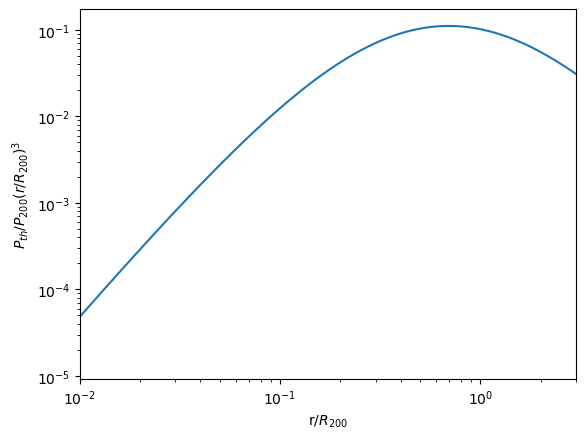

In [16]:
plt.plot(r/R200,Pth_rescaled) #Plot Battaglia 2012 pressure profile
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$P_{th}/P_{200}(r/R_{200})^3$')
plt.xlabel('r/$R_{200}$')
plt.xlim(.010,3)
plt.show()

In [22]:
y = szcluster.epp_to_y(szcluster.Pth_Battaglia2012, r, R200=R200, gamma=-0.3,alpha=1.0,beta=beta,xc=xc,P0=P0)

In [23]:
y[0] #print central y value

0.01582396514378293

In [38]:
fSZ=szcluster.f_sz(30,cosmo.Tcmb0) #get f_SZ for observation frequency of 30 GHz
dT=cosmo.Tcmb0*y[0]*fSZ #get dT from y0 using f_SZ
dT=dT.to(u.uK) #Convert to uK
print(dT)

-84243.63050890232 uK
